## 1.提取DBC文件信息转为数据域分割的GroundTruth

In [1]:
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
node = []
allDatas = []
siganlList = []
SignalsName = []
messageName = []

In [2]:
def readFile(file_name):
    global node,allDatas,siganlList,SignalsName,messageName
    ''' 得到dbc文件的绝对路径'''
    filePath = file_name
    if filePath:
        print(filePath)
        f = open(filePath, "r")  # 设置文件对象
    else:
        print("读取文件失败！")
        return 0
    """
    NodesPattern:节点
    MessagePattern：消息
    SignalPattern：信号
    """
    NodesPattern = re.compile(r"BU_: (.*)", re.S)
    MessagePattern = re.compile(r"BO_ (.*?) (.*?): (.*?) (.*)", re.S)
#     SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@.*? \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@([0-9])([+|-]) \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    DefaultValue = '''BA_ "GenSig(.*?)" SG_ (\d+) signalname (\d+);'''

    line = f.readline()
    allDatas=[]
    while line:
        """ 匹配出节点 """
        NodesSearched = re.search(NodesPattern, line.strip())
        if NodesSearched:
            node = NodesSearched.group(1).split(" ")
            #print(node)
        """ 匹配出消息 """
        MessageSearched = re.search(MessagePattern, line.strip())
        if MessageSearched:
            siganlList.clear()
            """如果匹配到了message，则获取到message的相关参数 
             比如匹配到了NM_Message_ESC_409，则会解析出改message的一些参数构成list对象['1033', 'NM_Message_ESC_409', '8', 'ESC']
             这四个参数分别是 messgage ID ;message name ; messgae dataLenth ,message sender
             而且把这个list对象 加在了 siganlList 索引0的位置
            """
            Message = list(MessageSearched.groups())
            siganlList.append(Message)
            """ 只 要 message的名字 messageName 列表中"""
            messageName.append(Message[1])
            """读取下一行"""
            line = f.readline()
            """因为有些message并没有定义signal，所以 下一行还是message"""
            MessageSearched = re.search(MessagePattern, line.strip())
            SignalSearched = re.search(SignalPattern, line.strip())
            """下一行如果不是message的内容 就一定是signal的内容了"""
            if not MessageSearched:
                while SignalSearched:
                    """获取信号的参数追加到siganlList"""
                    signal = list(SignalSearched.groups())
                    siganlList.append(signal)
                    """只获取 signal name"""
                    SignalsName.append(signal[0])

                    # 再次解析信号，直到这个message下的信号全部解析完毕
                    line = f.readline()
                    SignalSearched = re.search(SignalPattern, line.strip())
           # print(siganlList)
            c = copy.deepcopy(siganlList)
            allDatas.append(c)
        else:
            line = f.readline()
            MessageSearched = re.search(MessagePattern, line.strip())
    f.close()  # 将文件关闭
    return 1

In [3]:
import os
file_names = []
path = os.path.abspath('../My_DBC')
# path = os.path.abspath('../opendbc-master/opendbc-master-delFalseData')
# path = os.path.abspath('./opendbc-master/opendbc-master')
dirs = os.listdir(path)                    # 获取指定路径下的文件
for i in dirs:
    if os.path.splitext(i)[1] == ".dbc":
        file_names.append(os.path.join(path,i))
file_names

['D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_object.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\gm_global_a_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_sedan_16_diesel_2019_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_touring_2016_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_can.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_powertrain.dbc',
 'D:\\--storage-

## 2.处理原始bit数据和GroundTruth数据的函数

In [4]:
def get_id_labels(index):
    file_name = file_names[index]
    readFile(file_name)

    # 将DBC文件中的ID(10进制数)改为ID(16进制数)
    data_gts = {}
    for alldata in allDatas:
        data_gts[str(hex(int(alldata[0][0])))[2:]] = alldata

    # 得到DBC文件中各ID Message对应信号位置
    all_id_lsbs = {}
    for k in data_gts.keys():
        message = data_gts[k]
        lsb_list = []
        series = np.zeros(64)
        message_id = message[0][0]+"_"+message[0][1]
        del message[0]
        for signal in message:
            start = int(signal[1])
            length = int(signal[2])
            endianness = int(signal[3])
            start_row = int(start / 8)
            start_col = 8 - (start - start_row * 8) - 1
            new_start = start_row * 8 + start_col
            if endianness == 0:
                new_end = new_start + length
                cur_lsb = new_end - 1
            if endianness == 1:
                cur_lsb = new_start
            lsb_list.append(cur_lsb)
        all_id_lsbs[k] = lsb_list

    # 将各ID Message的信号位置改为 0/1 label
    all_id_labels = {}
    for k in all_id_lsbs:
        cur_lsb_list = all_id_lsbs[k]
        cur_label = np.zeros(64)
        for cur_lsb in cur_lsb_list:
            cur_label[cur_lsb] = 1
        all_id_labels[k] = cur_label
    return all_id_lsbs, all_id_labels

In [5]:
def get_ids(id_tracedict_int, all_id_labels):
    ids = []
    for id in id_tracedict_int.keys():
        if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
            ids.append(id)
    return ids

In [6]:
def get_trace(data):
    group = data.groupby(by="ID")
    id_tracedict = {}
    for trace in list(group):
        id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).apply(lambda x: list(map(int, x))).tolist()
    return id_tracedict

In [7]:
import random
# 设置全局的随机种子
random.seed(100)
# 以id为单位shuffle
# def get_train_test_ids(id_tracedict, all_id_labels):
#     ids = get_ids(id_tracedict, all_id_labels)
# #     random.shuffle(ids)
#     ids.sort()
#     train_len = int(len(ids)*0.7)
#     train_ids = ids[:train_len]
#     test_ids = ids[train_len:]
#     return train_ids, test_ids

In [8]:
def get_trace_data_dict(cur_ids, id_tracedict_int, all_id_labels, trace_data_dict, trace_label_dict): 
    for id in cur_ids:
        trace_data_dict[id] = id_tracedict_int[id]
        trace_label_dict[id] = all_id_labels[id]

In [9]:
def rpad_0(cur_str, width):
    pad_len = width - len(cur_str)
    for i in range(pad_len):
        cur_str = cur_str + '0'
    return cur_str

## 3.综合Honda和Cadillac数据，得到训练集和测试集（包括0/1Label）

#### 得到label

In [10]:
# 合并所有Honda车的Ground Truth的 0/1 label
all_id_lsbs3, dict3 = get_id_labels(3)
all_id_lsbs4, dict4 = get_id_labels(4)
all_id_lsbs5, dict5 = get_id_labels(5)
honda_id_labels = dict()
for key in dict3.keys() | dict4.keys() | dict5.keys():
    for d in (dict3, dict4, dict5):
        if d.__contains__(key):
            honda_id_labels[key] = d[key]
            break
honda_id_lsb = dict()
for key in all_id_lsbs3.keys() | all_id_lsbs4.keys() | all_id_lsbs5.keys():
    for d in (all_id_lsbs3, all_id_lsbs4, all_id_lsbs5):
        if d.__contains__(key):
            honda_id_lsb[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_hatchback_ex_2017_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_sedan_16_diesel_2019_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_touring_2016_can_generated.dbc


In [11]:
# 合并所有Cadillac以及Chevy车的Ground Truth的 0/1 label
all_id_lsbs0, dict0 = get_id_labels(0)
all_id_lsbs1, dict1 = get_id_labels(1)
all_id_lsbs2, dict2 = get_id_labels(2)
cadillac_id_labels = dict()
for key in dict0.keys() | dict1.keys() | dict2.keys():
    for d in (dict0, dict1, dict2):
        if d.__contains__(key):
            cadillac_id_labels[key] = d[key]
            break
cadillac_id_lsb = dict()
for key in all_id_lsbs0.keys() | all_id_lsbs1.keys() | all_id_lsbs2.keys():
    for d in (all_id_lsbs0, all_id_lsbs1, all_id_lsbs2):
        if d.__contains__(key):
            cadillac_id_lsb[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_object.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_powertrain.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\gm_global_a_powertrain.dbc


In [12]:
oct2bin = {"0":"0000","1":"0001","2":"0010","3":"0011","4":"0100","5":"0101","6":"0110","7":"0111","8":"1000","9":"1001",
           "a":"1010","b":"1011","c":"1100","d":"1101","e":"1110","f":"1111"}

In [13]:
def hex2bin(cur_hex):
    res = ""
    for i in cur_hex:
        res = res + oct2bin[i]
    res = rpad_0(res,64)
    return res

In [14]:
def plt_data_flip_dict(train_data_dict, train_label_dict):
    for id in train_data_dict.keys():
        messagelist = train_data_dict[id]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
    #     print("--------------------------------------------------------------------------------------------------------")
    #     print(id+": ")
        fig = plt.figure(figsize=(8,3))
        plt.bar(np.arange(64),bit_flip)
        plt.bar(np.arange(64),train_label_dict[id])

In [15]:
def clear_data_label_dict(true_train_ids, train_data_dict,train_label_dict):
    new_train_data_dict = {}
    new_train_label_dict = {}
    for i in range(len(train_data_dict)):
        if i in true_train_ids:
            id = list(train_data_dict.keys())[i]
            new_train_data_dict[id] = train_data_dict[id]
            new_train_label_dict[id] = train_label_dict[id]
    return new_train_data_dict, new_train_label_dict

In [16]:
def get_true_ids(true_train_ids, train_data_dict):
    true_ids = []
    for i in range(len(train_data_dict)):
        if i in true_train_ids:
            id = list(train_data_dict.keys())[i]
            true_ids.append(id)
    return true_ids

In [17]:
def get_trace_data(id_tracedict_int, all_id_labels): 
    cur_trace_data = []
    cur_trace_label = []
    for id in id_tracedict_int.keys():
        cur_trace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        length = len(cur_trace)
        start = 4000
        end = start + 1000
        n = int((length-4000)/1000)
        for i in range(n):
            cur_trace_data.append(cur_trace[start: end])
            cur_trace_label.append(cur_label)
            start = end
            end = start + 1000
    return cur_trace_data, cur_trace_label

#### honda数据集

In [18]:
# 得到Honda车的子数据集数据
data_hd = pd.read_csv('../Data/Honda_process_bin/honda001.csv')
# data_hd_1 = pd.read_csv('../Data/Honda_process_bin/honda001.csv')
# data_hd_2 = pd.read_csv('../Data/Honda_process_bin/honda002.csv')
# data_hd = pd.concat([data_hd_1,data_hd_2])

In [19]:
# 得到Honda车子的数据集的大Trace dict
id_tracedict_hd = get_trace(data_hd)
honda_ids = get_ids(id_tracedict_hd, honda_id_labels)
honda_data_dict = {}
honda_label_dict = {}
get_trace_data_dict(honda_ids, id_tracedict_hd, honda_id_labels, honda_data_dict, honda_label_dict)

In [20]:
true_honda_ids = [1,6,7,10,12, 13]

In [21]:
true_honda_idname = get_true_ids(true_honda_ids, honda_data_dict)
true_honda_idname

['158', '1d0', '1ea', '255', '309', '324']

In [22]:
new_honda_data_dict, new_honda_label_dict = clear_data_label_dict(true_honda_ids, honda_data_dict, honda_label_dict)

In [23]:
# plt_data_flip_dict(new_honda_data_dict, new_honda_label_dict)

In [24]:
honda_trace_data, honda_trace_label = get_trace_data(new_honda_data_dict, new_honda_label_dict)

#### cadillac数据集

In [25]:
# 得到Cadillac车的子数据集数据
data_cd = pd.read_csv('../Data/Cadillac_process_bin/001.txt.csv')
# data_cd_1 = pd.read_csv('../Data/Cadillac_process_bin/001.txt.csv')
# data_cd_2 = pd.read_csv('../Data/Cadillac_process_bin/002.txt.csv')
# data_cd = pd.concat([data_cd_1,data_cd_2])

In [26]:
# 得到Honda车子的数据集的大Trace dict
id_tracedict_cd = get_trace(data_cd)
cadillac_ids = get_ids(id_tracedict_cd, cadillac_id_labels)
cadillac_data_dict = {}
cadillac_label_dict = {}
get_trace_data_dict(cadillac_ids, id_tracedict_cd, cadillac_id_labels, cadillac_data_dict, cadillac_label_dict)

In [27]:
true_cadillac_ids = [8,9,10,11,15,19,21,26,27]

In [28]:
true_cadillac_idname = get_true_ids(true_cadillac_ids, cadillac_data_dict)
true_cadillac_idname

['17d', '180', '184', '1a1', '1e5', '260', '262', '348', '34a']

In [29]:
new_cadillac_data_dict, new_cadillac_label_dict = clear_data_label_dict(true_cadillac_ids, cadillac_data_dict, cadillac_label_dict)

In [30]:
# plt_data_flip_dict(cadillac_data_dict, cadillac_label_dict)
# plt_data_flip_dict(new_cadillac_data_dict, new_cadillac_label_dict)

In [31]:
cadillac_trace_data, cadillac_trace_label = get_trace_data(new_cadillac_data_dict, new_cadillac_label_dict)

#### chevy数据集

In [32]:
# 得到Chevy车的子数据集数据
data_ch = pd.read_csv('../Data/Chevy_process_bin/chevy001.csv')
# data_ch_2 = pd.read_csv('../Data/Chevy_process_bin/chevy002.csv')
# data_ch = pd.concat([data_ch_1,data_ch_2])

In [33]:
id_tracedict_ch = get_trace(data_ch)
chevy_ids = get_ids(id_tracedict_ch, cadillac_id_labels)

In [34]:
chevy_data_dict = {}
chevy_label_dict = {}
get_trace_data_dict(chevy_ids, id_tracedict_ch, cadillac_id_labels, chevy_data_dict, chevy_label_dict)

In [35]:
true_chevy_ids = [6,7,13,14,15,28]

In [36]:
true_chevy_idname = get_true_ids(true_chevy_ids, chevy_data_dict)
true_chevy_idname

['17d', '1a1', '32a', '348', '34a', 'be']

In [37]:
new_checy_data_dict, new_chevy_label_dict = clear_data_label_dict(true_chevy_ids, chevy_data_dict, chevy_label_dict)

In [38]:
# plt_data_flip_dict(chevy_data_dict, chevy_label_dict)
# plt_data_flip_dict(new_checy_data_dict, new_chevy_label_dict)

In [39]:
chevy_trace_data, chevy_trace_label = get_trace_data(new_checy_data_dict, new_chevy_label_dict)

#### 得到训练集和测试集

In [40]:
def get_data_label(id_tracedict_int, all_id_labels):
    cur_trace_data, cur_trace_label = get_trace_data(id_tracedict_int, all_id_labels)
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

In [41]:
def shuffle_data_label(cur_trace_data, cur_trace_label):
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

In [42]:
train_data = np.concatenate([honda_trace_data,cadillac_trace_data])
train_labels = np.concatenate([honda_trace_label,cadillac_trace_label])
train_data, train_labels = shuffle_data_label(train_data, train_labels)

In [43]:
test_data, test_labels = shuffle_data_label(chevy_trace_data, chevy_trace_label)

## DL Model

In [44]:
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, BatchNormalization, Flatten, MaxPooling1D, Conv1D,Conv2D, MaxPooling2D
from keras.layers import concatenate, add
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K
from sklearn import metrics
from keras.callbacks import Callback
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future 

In [ ]:
#### 之后需要加深Conv，增加maxpooling

In [281]:
# inputs = Input(shape = (1000,64,1))
# x = keras.layers.Conv2D(15, 3, padding='same', data_format='channels_last')(inputs)
# # x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# outputs = Dense(64, activation='sigmoid')(x)
# model = Model(inputs=inputs, outputs=outputs)
# # keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# keras.optimizers.Adam(lr=1e-3)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
# # model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[my_acc])
# model.summary()

In [ ]:
# inputs = Input(shape = (1000,64,1))
# x = Conv2D(60, (3,3), padding='same', data_format='channels_last')(inputs)
# x = Conv2D(30, (3,3), padding='same', data_format='channels_last')(x)
# x = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x)
# x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
# x = Flatten()(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.1)(x)
# outputs = Dense(64, activation='sigmoid')(x)
# model = Model(inputs=inputs, outputs=outputs)
# keras.optimizers.Adam(lr=1e-3)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
# model.summary()

In [204]:
# model_msb = Sequential()
# model_msb.add(Conv1D(256, 5, padding='same', input_shape = (1000,64)))
# model_msb.add(MaxPooling1D(3, 3, padding='same'))
# model_msb.add(Conv1D(128, 5, padding='same'))
# model_msb.add(MaxPooling1D(3, 3, padding='same'))
# model_msb.add(Conv1D(64, 3, padding='same'))
# model_msb.add(Flatten())
# model_msb.add(Dropout(0.1))
# model_msb.add(BatchNormalization())  # (批)规范化层
# model_msb.add(Dense(256, activation='relu'))
# model_msb.add(Dropout(0.1))
# model_msb.add(Dense(64, activation='sigmoid'))
# # model_msb.compile(loss=my_loss,optimizer='adam',metrics=['accuracy'])
# model_msb.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# # one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)  # 将标签转换为one-hot编码
# model_msb.summary()

In [205]:
# inputs = Input(shape = (1000,64,1))
# x = Conv2D(256, (3,3), padding='same', data_format='channels_last')(inputs)
# x = MaxPooling2D(pool_size=3, strides=3, padding='valid')(x)
# x = Conv2D(128, 3, padding='same', data_format='channels_last')(x)
# # x = MaxPooling2D(pool_size=3, strides=3, padding='valid')(x)
# x = Conv2D(64, 3, padding='same', data_format='channels_last')(x)
# x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
# x = Flatten()(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.1)(x)
# outputs = Dense(64, activation='sigmoid')(x)
# model = Model(inputs=inputs, outputs=outputs)
# keras.optimizers.Adam(lr=1e-3)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
# model.summary()

In [211]:
inputs = Input(shape = (1000,64,1))
x = Conv2D(60, (3,3), padding='same', data_format='channels_last')(inputs)
x = Conv2D(30, (3,3), padding='same', data_format='channels_last')(x)
x = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x)
x = Dropout(0.5)(x)
x = add([x,inputs])
x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(64, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
keras.optimizers.Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1000, 64, 1)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 1000, 64, 60) 600         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 1000, 64, 30) 16230       conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 1000, 64, 15) 4065        conv2d_14[0][0]                  
____________________________________________________________________________________________

In [179]:
# train_data_4 = np.expand_dims(cur_train_data, 3)
# test_data_4 = np.expand_dims(cur_test_data, 3)
train_data_4 = np.expand_dims(train_data, 3)
test_data_4 = np.expand_dims(test_data, 3)

In [180]:
mytrain_data = train_data_4
mytrain_labels = np.array(train_labels)
# mytrain_labels = np.array(cur_train_labels)

mytest_data = test_data_4
mytest_labels = np.array(test_labels)
# mytest_labels = np.array(cur_test_labels)

In [181]:
# model.fit(mytrain_data, mytrain_labels,epochs=5, batch_size=32)

In [220]:
history = model.fit(mytrain_data, mytrain_labels,
     epochs=1,
     batch_size=32,
     validation_data=(mytest_data, mytest_labels)
    )

Train on 285 samples, validate on 87 samples
Epoch 1/1
285/285 [==============================] - 44s 155ms/step - loss: 0.0123 - acc: 0.9972 - val_loss: 0.0858 - val_acc: 0.9779


In [66]:
# acc = history.history['acc']
# loss = history.history['loss']
# epochs = range(1, len(acc) + 1)

In [67]:
# plt.title('Accuracy')
# plt.plot(epochs, acc, 'red', label='Training acc')
# plt.plot(epochs, loss, 'blue', label='Training loss')
# plt.legend()
# plt.show()

In [216]:
print("训练集:")
predict_target_msb_prob = model.predict(mytrain_data)
predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
predict_target_msb_1D = predict_target_msb_label.flatten()
train_labels_1D = mytrain_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

训练集:
预测正确数量,训练集样本量:
18200 18240
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16935
         1.0       0.99      0.98      0.98      1305

    accuracy                           1.00     18240
   macro avg       0.99      0.99      0.99     18240
weighted avg       1.00      1.00      1.00     18240

混淆矩阵：
[[16918    17]
 [   23  1282]]


In [221]:
print("测试集:")
predict_target_test_msb_prob =model.predict(mytest_data)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = mytest_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

测试集:
预测正确数量,训练集样本量:
5445 5568
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5417
         1.0       0.58      0.66      0.62       151

    accuracy                           0.98      5568
   macro avg       0.79      0.82      0.80      5568
weighted avg       0.98      0.98      0.98      5568

混淆矩阵：
[[5345   72]
 [  51  100]]


## READ

In [82]:
# 使用READ方法计算bit-flip
import math
inf = -11
def get_preparation(trace_data):
    bit_Flips = []
    Magnitudes = []
    for i in range(len(trace_data)):
        messagelist = trace_data[i]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        magnitude = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
            if bit_flip[ix] == 0:
                cur_magnitude = inf
            else:
                cur_magnitude = math.log10(bit_flip[ix])
            magnitude[ix] = math.ceil(cur_magnitude)
        bit_Flips.append(bit_flip)
        Magnitudes.append(magnitude)
    return bit_Flips, Magnitudes

In [83]:
def get_phase1(magnitude):
    ref = []
    prevMagnitude = magnitude[0]
    ixS = 0
    for ix in range(64):
        if magnitude[ix] < prevMagnitude:
            ref.append((ixS, ix-1))
            ixS = ix
        prevMagnitude = magnitude[ix]
    ref.append((ixS, 63))
    return ref

In [84]:
def matchCounter(sublist):
    if(sublist[-1] != 1):
        return -1
    ixS = len(sublist)-1
    for i in range(len(sublist)-2,-1,-1):
        if sublist[i] == (sublist[i+1] / 2):
            ixS = i
    return ixS

In [85]:
def get_phase2(ref, bit_flip, magnitude):
    rRef = []
    for sign in ref:
        (ixS, ixE) = sign
        mgt = magnitude[ixS: ixE+1]
        mu = np.mean(bit_flip[ixS: ixE+1])
        std = np.std(bit_flip[ixS: ixE+1])
        if magnitude[ixE] == 0:
            Sctr = matchCounter(bit_flip[ixS: ixE+1])
#             print(Sctr)
            if Sctr >= 0:
                rRef.append((ixS, Sctr, "PHYSVAL"))
                rRef.append((Sctr, ixE, "COUNTER"))
        else:
            exit = False
            for Scrc in range(ixS, ixE+1):
                if not exit:
#                     print(Scrc)
                    if sum(magnitude[Scrc: (ixE+1)]) == 0 and mu >= (0.5-std) and mu <= (0.5+std):
                        rRef.append((Scrc, ixE, "CRC"))
                        rRef.append((ixS, Scrc, "PHYSVAL"))
                        exit = True
                else:
                    break
    return rRef

In [86]:
def position2preds(preds_ref):
    preds = []
    for i in range(len(preds_ref)):
        cur_ref = preds_ref[i]
        cur_preds = np.zeros(64)
        for signal in cur_ref:
            cur_preds[signal[1]] = 1
        preds.append(cur_preds)
    return np.array(preds)

In [87]:
def get_boundary_score(y_true, y_pred):
    new_labels = []
    new_preds = []
    for i in range(len(y_true)):
        if(y_true[i] == 1):
            new_labels.append(y_true[i])
            new_preds.append(y_pred[i])
    return np.array(new_labels), np.array(new_preds)

In [88]:
# READ_test_data = origin_trace
# READ_test_labels = origin_label

# READ_test_data = np.array(test_data_clear)
# READ_test_labels = np.array(test_labels_clear)

READ_test_data = np.array(test_data)
READ_test_labels = np.array(test_labels)

# READ_test_data = np.array(cur_test_data)
# READ_test_labels = np.array(cur_test_labels)

In [89]:
bit_flip_dict, magnitude_dict = get_preparation(READ_test_data)
preds_ref = []
preds_rRef = []
for i in range(len(magnitude_dict)):
    ref = get_phase1(magnitude_dict[i])
    rRef = get_phase2(ref, bit_flip_dict[i], magnitude_dict[i])
    preds_rRef.append(rRef)
    preds_ref.append(ref)
preds = position2preds(preds_ref)

In [90]:
# READ_test_labels[1]

In [91]:
len(bit_flip_dict)

87

In [92]:
# plt.bar(np.arange(64), bit_flip_dict[],label="bit-flip")
# # plt.bar(np.arange(64), READ_test_labels[10],label="label",color="black")
# plt.legend()

In [93]:
# plt.bar(np.arange(64), bit_flip_dict[3],label="bit-flip")
# plt.bar(np.arange(64), preds[3],label="preds")
# plt.legend()

In [94]:
# plt.bar(np.arange(64), magnitude_dict[1],label="magnitude")

In [95]:
from sklearn import metrics
print("测试集:")
preds_msb_1D = preds.flatten()
test_labels_1D = READ_test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(preds_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,preds_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,preds_msb_1D))

测试集:
预测正确数量,训练集样本量:
5353 5568
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      5417
         1.0       0.37      0.62      0.47       151

    accuracy                           0.96      5568
   macro avg       0.68      0.80      0.72      5568
weighted avg       0.97      0.96      0.97      5568

混淆矩阵：
[[5259  158]
 [  57   94]]


## 4.CAN-D数据特征提取函数

In [44]:
# 使用READ方法计算bit-flip
def get_bit_Flips(cur_id_traces):
    bit_Flips = []
    for i in range(len(cur_id_traces)):
        messagelist = cur_id_traces[i]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
        bit_flip = np.append(bit_flip, 0)
        bit_flip = np.append(bit_flip, 0)
        bit_Flips.append(bit_flip)
    return bit_Flips

In [45]:
# 使用READ方法计算bit-flip
def get_bit_Flips(cur_id_traces):
    bit_Flips = []
    for i in range(len(cur_id_traces)):
        messagelist = cur_id_traces[i]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
        bit_flip = np.append(bit_flip, 0)
        bit_flip = np.append(bit_flip, 0)
        bit_Flips.append(bit_flip)
    return bit_Flips

In [46]:
def del_constant_bit(cur_trace_data, cur_trace_label, bit_Flips):
    for i in range(len(bit_Flips)):
        cur_bit_flip = bit_Flips[i]
        cur_constant_bits = []
        for j in range(64):
            if cur_bit_flip[j] == 0:
                cur_constant_bits.append(j)
        a = cur_trace_data[i]
#         print(np.array(a).shape)
        b = []
        for temp in a:
            b.append([temp[j] for j in range(len(temp)) if j not in cur_constant_bits])
#         print(np.array(b).shape)
        cur_trace_data[i] = b
        temp = []
        for j in range(len(cur_trace_label[i])):
            next_j = j+1
            if j not in cur_constant_bits:
                if next_j in cur_constant_bits:
                    temp.append(1)
                else:
                    temp.append(cur_trace_label[i][j])
        cur_trace_label[i] = temp
#         cur_trace_label[i] = [temp[j] for j in range(len(temp)) if j not in cur_constant_bits]
        temp = bit_Flips[i]
        bit_Flips[i] = [temp[j] for j in range(len(temp)) if j not in cur_constant_bits]
    return cur_trace_data, cur_trace_label, bit_Flips

In [47]:
# 使用READ方法计算bit-flip的联合概率
def get_bit_Flip_LHs(cur_id_traces):
    bit_Flip_LHs = []
    bit_Flip_LH_nos = []
    for i in range(len(cur_id_traces)):
        messagelist = cur_id_traces[i]
        trace_len = len(messagelist)
        message_len = len(messagelist[0])
        bit_flip_LH = np.zeros(message_len)
        bit_flip_LH_no = np.zeros(message_len)
        previous_LH = messagelist[0]
        for item in messagelist:
            for ix in range(message_len-1):
                if item[ix] != previous_LH[ix] and item[ix+1] != previous_LH[ix+1]:
                    bit_flip_LH[ix] = bit_flip_LH[ix] + 1
                if item[ix] == previous_LH[ix] and item[ix+1] == previous_LH[ix+1]:
                    bit_flip_LH_no[ix] = bit_flip_LH_no[ix] + 1
            previous_LH = item
        for ix in range(message_len-1):
            bit_flip_LH[ix] = bit_flip_LH[ix] / trace_len
            bit_flip_LH_no[ix] = bit_flip_LH_no[ix] / trace_len

        bit_flip_LH = np.append(bit_flip_LH, 0)
        bit_flip_LH = np.append(bit_flip_LH, 0)
        bit_flip_LH_no = np.append(bit_flip_LH_no, 0)
        bit_flip_LH_no = np.append(bit_flip_LH_no, 0)

        bit_Flip_LHs.append(bit_flip_LH)
        bit_Flip_LH_nos.append(bit_flip_LH_no)
    return bit_Flip_LHs, bit_Flip_LH_nos

In [48]:
# reverse_id_tracelist 通过大端bit序列得到小端bit序列
def get_reverse_id_traces(cur_id_traces):
    reverse_id_traces = []
    for i in range(len(cur_id_traces)):
        id_tracelist = cur_id_traces[i]
        reverse_id_tracelist = []
        for item in id_tracelist:
            cur_tracelist = [0,1,2,3,4,5,6,7]
            cur_temp = []
            count = 7
            for i in range(64):
                cur_temp.append(item[i])
                if (i+1)%8 == 0:
                    cur_tracelist[count] = cur_temp
                    count = count - 1
                    cur_temp = []
            reverse_id_tracelist.append(np.concatenate(cur_tracelist).tolist())
        reverse_id_traces[i] = reverse_id_tracelist
    return reverse_id_traces

In [49]:
# 得到每个bit的15个特征
def get_sub_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i):
    f1 = bit_Flips[i][ix]
#     print(bit_Flips[i], i, ix)
    f2 = bit_Flips_LH[i][ix] / bit_Flips[i][ix+1]
    f3 = bit_Flips_LH[i][ix] / bit_Flips[i][ix]
    f4 = bit_Flip_LH_nos[i][ix] / (1 - bit_Flips[i][ix+1])
    f5 = bit_Flip_LH_nos[i][ix] / (1 - bit_Flips[i][ix])
    return np.array([f1,f2,f3,f4,f5])

def get_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i):
    cur_bit_feature = []
    feature_sub1 = get_sub_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i)
    feature_sub2 = get_sub_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix+1, i)
    feature_sub3 = feature_sub2 - feature_sub1
    return np.concatenate((feature_sub1,feature_sub2,feature_sub3))

In [50]:
# 为每个bit赋予15个特征
def get_bit_features_list(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos):
    bit_features_list = []
    for i in range(len(bit_Flips)):
        bit_features = []
        for ix in range(len(bit_Flips[i])-2):
            bit_features.append(get_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i))
        bit_features_list.append(bit_features)
    return bit_features_list

In [51]:
# 小端转成大端的正常格式，方便与上边生成的ground truth label匹配
def LE_to_BE(reverse_bit_features_list):
    bit_features_list = []
    for i in range(len(reverse_bit_features_list)):
        item = reverse_bit_features_dict[i]
        cur_bit_features = [0,1,2,3,4,5,6,7]
        cur_temp = []
        count = 7
        for i in range(64):
            cur_temp.append(item[i])
            if (i+1)%8 == 0:
                cur_bit_features[count] = cur_temp
                count = count - 1
                cur_temp = []
        bit_features_list.append(np.concatenate(cur_bit_features).tolist())
    return bit_features_list

In [52]:
# 得到Trace与Ground Truth都存在的id
def get_all_datas_labels(bit_features_list, cur_id_labels):
    alldatas = []
    alllabels = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for i in range(len(cur_features)):
            alldatas.append(cur_features[i])
            alllabels.append(int(cur_labels[i]))
    return alldatas, alllabels

In [53]:
def get_shuffle_data_label(cur_trace_data, cur_trace_label):
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

## 5.训练大端的RF模型，去掉constant bit

### 预训练模型

In [54]:
# train_id_traces, train_id_labels = get_trace_data(train_data_dict, train_label_dict)

In [55]:
# np.array(train_id_labels).shape

In [56]:
# np.array(cur_train_data).shape

In [57]:
# train_id_traces, train_id_labels = get_trace_data(train_data_dict, train_label_dict)
train_id_traces = train_data.tolist()
train_id_labels = train_labels.tolist()
bit_Flips_train = get_bit_Flips(train_id_traces)
train_id_traces, train_id_labels, bit_Flips_train = del_constant_bit(train_id_traces, train_id_labels, bit_Flips_train)
bit_Flip_LHs_train, bit_Flip_LH_nos_train = get_bit_Flip_LHs(train_id_traces)
bit_features_list_train = get_bit_features_list(bit_Flips_train, bit_Flip_LHs_train, bit_Flip_LH_nos_train)
traindatas_msb, trainlabels_msb = get_all_datas_labels(bit_features_list_train, train_id_labels)

D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [58]:
# test_id_traces, test_id_labels = get_trace_data(test_data_dict, test_label_dict)
test_id_traces = test_data.tolist()
test_id_labels = test_labels.tolist()
bit_Flips_test = get_bit_Flips(test_id_traces)
test_id_traces, test_id_labels, bit_Flips_test = del_constant_bit(test_id_traces, test_id_labels, bit_Flips_test)
bit_Flip_LHs_test, bit_Flip_LH_nos_test = get_bit_Flip_LHs(test_id_traces)
bit_features_list_test = get_bit_features_list(bit_Flips_test, bit_Flip_LHs_test, bit_Flip_LH_nos_test)
testdatas_msb, testlabels_msb = get_all_datas_labels(bit_features_list_test, test_id_labels)

D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [59]:
traindatas_msb, trainlabels_msb = get_shuffle_data_label(traindatas_msb, trainlabels_msb)
testdatas_msb, testlabels_msb = get_shuffle_data_label(testdatas_msb, testlabels_msb)

In [60]:
Traindata_msb = pd.DataFrame(traindatas_msb)
Traindata_msb['label'] = np.array(trainlabels_msb)
Traindata_msb = Traindata_msb.fillna(0)
traindatas_msb = np.array(Traindata_msb.iloc[:,:15])
trainlabels_msb = np.array(Traindata_msb.iloc[:,-1])

In [61]:
Testdata_msb = pd.DataFrame(testdatas_msb)
Testdata_msb['label'] = np.array(testlabels_msb)
Testdata_msb = Testdata_msb.fillna(0)
testdatas_msb = np.array(Testdata_msb.iloc[:,:15])
testlabels_msb = np.array(Testdata_msb.iloc[:,-1])

In [62]:
#随机森林方法
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model_msb = RandomForestClassifier(n_estimators= 30)
model_msb.fit(traindatas_msb, trainlabels_msb)

print("训练集:")
predict_target_msb = model_msb.predict(traindatas_msb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb == trainlabels_msb),len(trainlabels_msb))
print("训练集精确度等指标：")
print(metrics.classification_report(trainlabels_msb,predict_target_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_msb,predict_target_msb))

print("测试集:")
predict_target_test_msb =model_msb.predict(testdatas_msb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb == testlabels_msb),len(testlabels_msb))
print("测试集精确度等指标：")
print(metrics.classification_report(testlabels_msb,predict_target_test_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_msb,predict_target_test_msb))

训练集:
预测正确数量,训练集样本量:
10207 10223
训练集精确度等指标：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8973
           1       1.00      0.99      0.99      1250

    accuracy                           1.00     10223
   macro avg       1.00      0.99      1.00     10223
weighted avg       1.00      1.00      1.00     10223

混淆矩阵：
[[8971    2]
 [  14 1236]]
测试集:
预测正确数量,训练集样本量:
816 840
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       680
           1       0.99      0.86      0.92       160

    accuracy                           0.97       840
   macro avg       0.98      0.93      0.95       840
weighted avg       0.97      0.97      0.97       840

混淆矩阵：
[[679   1]
 [ 23 137]]


### 微调模型

In [63]:
# train_id_traces_f, train_id_labels_f = get_trace_data(train_data_dict, train_label_dict)
# train_id_traces_f, train_id_labels_f = cur_train_data.tolist(), train_labels.tolist()
train_id_traces_f = train_data.tolist()
train_id_labels_f = train_labels.tolist()
bit_Flips_train_f = get_bit_Flips(train_id_traces_f)
bit_Flip_LHs_train_f, bit_Flip_LH_nos_train_f = get_bit_Flip_LHs(train_id_traces_f)
bit_features_list_train_f = get_bit_features_list(bit_Flips_train_f, bit_Flip_LHs_train_f, bit_Flip_LH_nos_train_f)
traindatas_msb_f, trainlabels_msb_f = get_all_datas_labels(bit_features_list_train_f, train_id_labels_f)

D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [64]:
# test_id_traces_f, test_id_labels_f = get_trace_data(test_data_dict, test_label_dict)
# test_id_traces_f, test_id_labels_f = test_data.tolist(), test_labels.tolist()
test_id_traces_f = test_data.tolist()
test_id_labels_f = test_labels.tolist()
bit_Flips_test_f = get_bit_Flips(test_id_traces_f)
bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f = get_bit_Flip_LHs(test_id_traces_f)
bit_features_list_test_f = get_bit_features_list(bit_Flips_test_f, bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f)
testdatas_msb_f, testlabels_msb_f = get_all_datas_labels(bit_features_list_test_f, test_id_labels_f)

D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [65]:
traindatas_msb_f, trainlabels_msb_f = get_shuffle_data_label(traindatas_msb_f, trainlabels_msb_f)
testdatas_msb_f, testlabels_msb_f = get_shuffle_data_label(testdatas_msb_f, testlabels_msb_f)

Traindata_msb_f = pd.DataFrame(traindatas_msb_f)
Traindata_msb_f['label'] = np.array(trainlabels_msb_f)
Traindata_msb_f = Traindata_msb_f.fillna(0)
traindatas_msb_f = np.array(Traindata_msb_f.iloc[:,:15])
trainlabels_msb_f = np.array(Traindata_msb_f.iloc[:,-1])

Testdata_msb_f = pd.DataFrame(testdatas_msb_f)
Testdata_msb_f['label'] = np.array(testlabels_msb_f)
Testdata_msb_f = Testdata_msb_f.fillna(0)
testdatas_msb_f = np.array(Testdata_msb_f.iloc[:,:15])
testlabels_msb_f = np.array(Testdata_msb_f.iloc[:,-1])

In [66]:
def is_nonobvious_boundary(cur_features, j):
    if j == 0:
        if cur_features[1][0] != 0:
            return True
        else:
            return False
    if j == 63:
        if cur_features[62][0] != 0:
            return True
        else:
            return False
    if cur_features[j-1][0] != 0 and cur_features[j+1][0] != 0:
        return True
    return False

In [67]:
def get_tun_data_label(bit_features_list, cur_id_labels):
    nonobvious_boundaries = []
    nonobvious_boundaries_label = []
    obvious_boundaries = []
    obvious_boundaries_label = []
    negative_bit = []
    negativ_bit_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 0:
                negative_bit.append(cur_features[j])
                negativ_bit_label.append(int(cur_labels[j]))
            elif is_nonobvious_boundary(cur_features, j):
                nonobvious_boundaries.append(cur_features[j])
                nonobvious_boundaries_label.append(int(cur_labels[j]))
            else:
                obvious_boundaries.append(cur_features[j])
                obvious_boundaries_label.append(int(cur_labels[j]))
#     print(np.array(obvious_boundaries).shape)
    len_nb = len(nonobvious_boundaries_label)
    len_ne = int(len_nb/8 * 4)
    len_ob = int(len_nb/8)
    train_data = np.concatenate([nonobvious_boundaries, negative_bit[:len_ne], obvious_boundaries[:len_ob]])
    train_label = np.concatenate([nonobvious_boundaries_label, negativ_bit_label[:len_ne], obvious_boundaries_label[:len_ob]])
    tun_data, tun_label = get_shuffle_data_label(train_data, train_label)
    return tun_data, tun_label

In [68]:
def get_test_data_label(bit_features_list, cur_id_labels):
    nonobvious_boundaries = []
    nonobvious_boundaries_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 1 and is_nonobvious_boundary(cur_features, j):
                nonobvious_boundaries.append(cur_features[j])
                nonobvious_boundaries_label.append(int(cur_labels[j]))
    test_data, test_label = get_shuffle_data_label(nonobvious_boundaries, nonobvious_boundaries_label)
    return test_data, test_label

In [69]:
def get_data_label_boundary(bit_features_list, cur_id_labels):
    boundaries = []
    boundaries_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 1:
                boundaries.append(cur_features[j])
                boundaries_label.append(int(cur_labels[j]))
    test_data, test_label = get_shuffle_data_label(boundaries, boundaries_label)
    return test_data, test_label

In [70]:
def get_data_label_boundary_constant(bit_features_list, cur_id_labels):
    nonobvious_boundaries = []
    nonobvious_boundaries_label = []
    negative_bit = []
    negativ_bit_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 0:
                negative_bit.append(cur_features[j])
                negativ_bit_label.append(int(cur_labels[j]))
            elif is_nonobvious_boundary(cur_features, j):
                nonobvious_boundaries.append(cur_features[j])
                nonobvious_boundaries_label.append(int(cur_labels[j]))
    train_data = np.concatenate([nonobvious_boundaries, negative_bit])
    train_label = np.concatenate([nonobvious_boundaries_label, negativ_bit_label])
    tun_data, tun_label = get_shuffle_data_label(train_data, train_label)
    return tun_data, tun_label

In [71]:
tun_data, tun_label = get_tun_data_label(bit_features_list_train_f, train_id_labels_f)

Traindata_msb_f = pd.DataFrame(tun_data)
Traindata_msb_f['label'] = np.array(tun_label)
Traindata_msb_f = Traindata_msb_f.fillna(0)
tun_data = np.array(Traindata_msb_f.iloc[:,:15])
tun_label = np.array(Traindata_msb_f.iloc[:,-1])

In [72]:
np.array(test_id_labels_f).shape

(87, 64)

In [75]:
# tun_data_2, tun_label_2 = get_tun_data_label(bit_features_list_test_f, test_id_labels_f)

# Traindata_msb_f = pd.DataFrame(tun_data_2)
# Traindata_msb_f['label'] = np.array(tun_label_2)
# Traindata_msb_f = Traindata_msb_f.fillna(0)
# tun_data_2 = np.array(Traindata_msb_f.iloc[:,:15])
# tun_label_2 = np.array(Traindata_msb_f.iloc[:,-1])

In [ ]:
# tun_test_data, tun_test_label = get_test_data_label(bit_features_list_test_f, test_id_labels_f)

# Testdata_msb_f = pd.DataFrame(tun_test_data)
# Testdata_msb_f['label'] = np.array(tun_test_label)
# Testdata_msb_f = Testdata_msb_f.fillna(0)
# tun_test_data = np.array(Testdata_msb_f.iloc[:,:15])
# tun_test_label = np.array(Testdata_msb_f.iloc[:,-1])

In [ ]:
# bit_features_list_f = np.concatenate([bit_features_list_train_f,bit_features_list_test_f])
# id_labels_f = np.concatenate([train_id_labels_f,test_id_labels_f])

# tun_test_data_all, tun_test_label_all = get_test_data_label(bit_features_list_f, id_labels_f)

# Testdata_msb_f = pd.DataFrame(tun_test_data_all)
# Testdata_msb_f['label'] = np.array(tun_test_label_all)
# Testdata_msb_f = Testdata_msb_f.fillna(0)
# tun_test_data_all = np.array(Testdata_msb_f.iloc[:,:15])
# tun_test_label_all = np.array(Testdata_msb_f.iloc[:,-1])

In [ ]:
# bit_features_list_f = np.concatenate([bit_features_list_train_f,bit_features_list_test_f])
# id_labels_f = np.concatenate([train_id_labels_f,test_id_labels_f])

# tun_test_data_boundary, tun_test_label_boundary = get_data_label_boundary(bit_features_list_f, id_labels_f)

# Testdata_msb_f = pd.DataFrame(tun_test_data_boundary)
# Testdata_msb_f['label'] = np.array(tun_test_label_boundary)
# Testdata_msb_f = Testdata_msb_f.fillna(0)
# tun_test_data_boundary = np.array(Testdata_msb_f.iloc[:,:15])
# tun_test_label_boundary = np.array(Testdata_msb_f.iloc[:,-1])

In [ ]:
# f1_data, f1_label = get_data_label_boundary_constant(bit_features_list_train_f, train_id_labels_f)

# Traindata_msb_f = pd.DataFrame(f1_data)
# Traindata_msb_f['label'] = np.array(f1_label)
# Traindata_msb_f = Traindata_msb_f.fillna(0)
# f1_data = np.array(Traindata_msb_f.iloc[:,:15])
# f1_label = np.array(Traindata_msb_f.iloc[:,-1])

In [73]:
param_distribution = [
    {'n_estimators' : [90,150,200,250,300], 'max_features' : [1, 2, 3, 4, 5, 6], 
     'max_depth':[1,2,3,4,5],'min_samples_leaf':[3,4,5,6]},
#     {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]},
]
 
from sklearn.model_selection import RandomizedSearchCV
# from scikitlearn.scikit_learn.sklearn.model_selection._search import RandomizedSearchCV
 
random_search_cv = RandomizedSearchCV(model_msb,
                                      param_distribution,
                                      n_iter = 50,#从param_distribution里sample出多少个参数集合
                                      cv = 10,
                                      scoring='neg_mean_squared_error',
#                                       scoring=my_scores,
                                      n_jobs = 1) #有多少任务并行处理
# random_search_cv.fit(traindatas_msb_f, trainlabels_msb_f)
random_search_cv.fit(tun_data, tun_label)
 
# 在超参数搜索时有cross_validation机制: 训练集分成n份，n-1训练，最后一份验证.
# 在超参数搜索完之后，会在全部训练集上用新的参数再训练一遍
 
print(random_search_cv.best_params_) #最好参数
print(random_search_cv.best_score_) #最好分值
print(random_search_cv.best_estimator_) #最好的model

{'n_estimators': 200, 'min_samples_leaf': 3, 'max_features': 6, 'max_depth': 5}
-0.04662004662004662
RandomForestClassifier(max_depth=5, max_features=6, min_samples_leaf=3,
                       n_estimators=200)


In [74]:
model_tunning = random_search_cv.best_estimator_

In [75]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(tun_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == tun_label),len(tun_label))
print("训练集精确度等指标：")
print(metrics.classification_report(tun_label,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_label,predict_target_msb_f))

训练集:
预测正确数量,训练集样本量:
751 774
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       238
           1       0.98      0.98      0.98       536

    accuracy                           0.97       774
   macro avg       0.97      0.96      0.97       774
weighted avg       0.97      0.97      0.97       774

混淆矩阵：
[[226  12]
 [ 11 525]]


In [76]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(tun_data_2)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == tun_label_2),len(tun_label_2))
print("训练集精确度等指标：")
print(metrics.classification_report(tun_label_2,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_label_2,predict_target_msb_f))

训练集:


NameError: name 'tun_data_2' is not defined

In [ ]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(tun_test_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == tun_test_label),len(tun_test_label))
print("测试集精确度等指标：")
print(metrics.classification_report(tun_test_label,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_test_label,predict_target_test_msb_f))

In [ ]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(tun_test_data_all)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == tun_test_label_all),len(tun_test_label_all))
print("测试集精确度等指标：")
print(metrics.classification_report(tun_test_label_all,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_test_label_all,predict_target_test_msb_f))

In [ ]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(tun_test_data_boundary)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == tun_test_label_boundary),len(tun_test_label_boundary))
print("测试集精确度等指标：")
print(metrics.classification_report(tun_test_label_boundary,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_test_label_boundary,predict_target_test_msb_f))

In [ ]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(traindatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == trainlabels_msb_f),len(trainlabels_msb_f))
print("训练集精确度等指标：")
print(metrics.classification_report(trainlabels_msb_f,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_msb_f,predict_target_msb_f))

In [ ]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(f1_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == f1_label),len(f1_label))
print("训练集精确度等指标：")
print(metrics.classification_report(f1_label,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(f1_label,predict_target_msb_f))

In [236]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(testdatas_msb_f)
# predict_target_test_msb_f =model_msb.predict(testdatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == testlabels_msb_f),len(testlabels_msb_f))
print("测试集精确度等指标：")
print(metrics.classification_report(testlabels_msb_f,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_msb_f,predict_target_test_msb_f))

测试集:
预测正确数量,训练集样本量:
5425 5568
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5417
           1       0.52      0.62      0.57       151

    accuracy                           0.97      5568
   macro avg       0.76      0.80      0.78      5568
weighted avg       0.98      0.97      0.98      5568

混淆矩阵：
[[5332   85]
 [  58   93]]


In [237]:
predict_target_test_msb_f

array([0, 0, 0, ..., 0, 0, 0])

In [238]:
predict_target_test_msb_f.sum()

178

In [239]:
testlabels_msb_f.sum()

151

In [240]:
count  = 0
for i in range(len(predict_target_test_msb_f)):
    if predict_target_test_msb_f[i] == 1 and testlabels_msb_f[i] == 1:
        count  = count + 1
count

93

In [224]:
cur_data_dict = {}
cur_label_dict = {}
# '1a1', '32a', '348', 'be'
id = 'be'
# id = '348'
# id = "32a"
# id = '1a1'
# cur_data_dict[id] = test_data_dict[id]
# cur_label_dict[id] = test_label_dict[id]
# cur_data,cur_label = get_trace_data(cur_data_dict, cur_label_dict)
test_message_1 = {}
test_message_label_1 = {}
test_message_1[id] = new_checy_data_dict[id]
test_message_label_1[id] = new_chevy_label_dict[id]
cur_data,cur_label = get_trace_data(test_message_1, test_message_label_1)

In [225]:
# bit_Flips_test_f = get_bit_Flips(cur_data)
# bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f = get_bit_Flip_LHs(test_id_traces_f)
# bit_features_list_test_f = get_bit_features_list(bit_Flips_test_f, bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f)
# curdatas_msb_f, curlabels_msb_f = get_all_datas_labels(bit_features_list_test_f, cur_label)

In [226]:
bit_Flips_test_f = get_bit_Flips(cur_data)
bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f = get_bit_Flip_LHs(cur_data)
bit_features_list_test_f = get_bit_features_list(bit_Flips_test_f, bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f)
curdatas_msb_f, curlabels_msb_f = get_all_datas_labels(bit_features_list_test_f, cur_label)

D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [227]:
Testdata_msb_f = pd.DataFrame(curdatas_msb_f)
Testdata_msb_f['label'] = np.array(curlabels_msb_f)
Testdata_msb_f = Testdata_msb_f.fillna(0)
curdatas_msb_f = np.array(Testdata_msb_f.iloc[:,:15])
curlabels_msb_f = np.array(Testdata_msb_f.iloc[:,-1])

In [228]:
testdata = curdatas_msb_f[:64]
testlabel = curlabels_msb_f[:64]

测试集:
预测正确数量,训练集样本量:
63 64
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      0.50      0.67         2

    accuracy                           0.98        64
   macro avg       0.99      0.75      0.83        64
weighted avg       0.98      0.98      0.98        64

混淆矩阵：
[[62  0]
 [ 1  1]]


<BarContainer object of 64 artists>

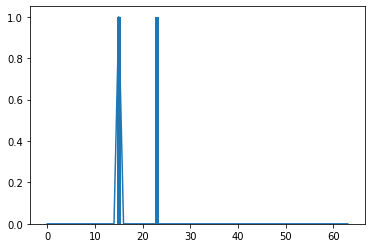

In [230]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(testdata)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == testlabel),len(testlabel))
print("测试集精确度等指标：")
print(metrics.classification_report(testlabel,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabel,predict_target_test_msb_f))
plt.plot(predict_target_test_msb_f)
plt.bar(np.arange(64),testlabel)

In [231]:
# (pd.DataFrame(testdata)).iloc[:60,:]

<BarContainer object of 64 artists>

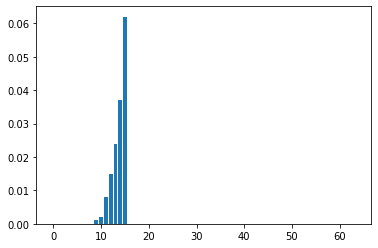

In [232]:
plt.bar(np.arange(64),bit_Flips_test_f[0][:64])

In [233]:
for i in range(len(predict_target_test_msb_f)):
    if predict_target_test_msb_f[i] == 1:
        print(i)

15


In [106]:
def clip_list(arr, length):
    res = []
    last_i = 0
    for i in range(length,len(arr),length):
        res.append(arr[last_i:i])
        last_i = i
    res.append(arr[last_i:len(arr)])
    return res

In [113]:
import sklearn
def cal_score_mean(labels, preds):
    new_labels = clip_list(labels,64)
    new_preds = clip_list(preds,64)
    f1_score = 0
    precision_score = 0
    recall_score = 0
    for i in range(len(new_labels)):
        cur_label = new_labels[i]
        cur_pred = new_preds[i]
        f1_score = f1_score + sklearn.metrics.f1_score(cur_label, cur_pred)
        precision_score = precision_score + sklearn.metrics.precision_score(cur_label, cur_pred)
        recall_score = recall_score + sklearn.metrics.recall_score(cur_label, cur_pred)
    res_f1_score = f1_score / len(new_labels)
    res_precision_score = precision_score / len(new_labels)
    res_recall_score = recall_score / len(new_labels)
    return res_precision_score, res_recall_score, res_f1_score

In [119]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(traindatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == trainlabels_msb_f),len(trainlabels_msb_f))
print("训练集精确度等指标：")
res_precision_score, res_recall_score, res_f1_score = cal_score_mean(trainlabels_msb_f,predict_target_msb_f)
print(res_precision_score, res_recall_score, res_f1_score)
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_msb_f,predict_target_msb_f))

print("测试集:")
predict_target_test_msb_f =model_tunning.predict(testdatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == testlabels_msb_f),len(testlabels_msb_f))
print("测试集精确度等指标：")
res_precision_score_test, res_recall_score_test, res_f1_score_test = cal_score_mean(testlabels_msb_f,predict_target_test_msb_f)
print(res_precision_score_test, res_recall_score_test, res_f1_score_test)
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_msb_f,predict_target_test_msb_f))

训练集:
预测正确数量,训练集样本量:
79240 120000
训练集精确度等指标：


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this 

0.10733179380598669 0.5150875805675805 0.17253723704633905
混淆矩阵：
[[74831 36619]
 [ 4141  4409]]
测试集:
预测正确数量,训练集样本量:
11401 16128
测试集精确度等指标：


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this 

0.12101254383273913 0.5534653507867794 0.19326915181059473
混淆矩阵：
[[10806  4272]
 [  455   595]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# print("训练集:")
# predict_target_msb_f = model_msb.predict(traindatas_msb_f)
# print("预测正确数量,训练集样本量:")
# print(sum(predict_target_msb_f == trainlabels_msb_f),len(trainlabels_msb_f))
# print("训练集精确度等指标：")
# print(metrics.classification_report(trainlabels_msb_f,predict_target_msb_f))
# print("混淆矩阵：")
# print(metrics.confusion_matrix(trainlabels_msb_f,predict_target_msb_f))

# print("测试集:")
# predict_target_test_msb_f =model.predict(testdatas_msb_f)
# print("预测正确数量,训练集样本量:")
# print(sum(predict_target_test_msb_f == testlabels_msb_f),len(testlabels_msb_f))
# print("测试集精确度等指标：")
# print(metrics.classification_report(testlabels_msb_f,predict_target_test_msb_f))
# print("混淆矩阵：")
# print(metrics.confusion_matrix(testlabels_msb_f,predict_target_test_msb_f))

## 训练小端的RF模型

In [68]:
reverse_train_data_dict = get_reverse_id_tracedict(train_data_dict)
reverse_bit_flip_dict_train = get_bit_flip_dict(reverse_train_data_dict)
reverse_bit_flip_LH_dict_train, reverse_bit_flip_LH_no_dict_train = get_bit_flip_LH_dict(reverse_train_data_dict)
reverse_bit_features_dict_train = get_bit_features_dict(reverse_bit_flip_dict_train, reverse_bit_flip_LH_dict_train, reverse_bit_flip_LH_no_dict_train)
bit_features_dict_train_lsb = LE_to_BE(reverse_bit_features_dict_train)
traindatas_lsb, trainlabels_lsb = get_all_datas_labels(bit_features_dict_train_lsb, train_label_dict)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [69]:
reverse_test_data_dict = get_reverse_id_tracedict(test_data_dict)
reverse_bit_flip_dict_test = get_bit_flip_dict(reverse_test_data_dict)
reverse_bit_flip_LH_dict_test, reverse_bit_flip_LH_no_dict_test = get_bit_flip_LH_dict(reverse_test_data_dict)
reverse_bit_features_dict_test = get_bit_features_dict(reverse_bit_flip_dict_test, reverse_bit_flip_LH_dict_test, reverse_bit_flip_LH_no_dict_test)
bit_features_dict_test_lsb = LE_to_BE(reverse_bit_features_dict_test)
testdatas_lsb, testlabels_lsb = get_all_datas_labels(bit_features_dict_test_lsb, test_label_dict)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [70]:
traindatas_lsb, trainlabels_lsb = get_shuffle_data_label(traindatas_lsb, trainlabels_lsb)
testdatas_lsb, testlabels_lsb = get_shuffle_data_label(testdatas_lsb, testlabels_lsb)

In [71]:
Traindata_lsb = pd.DataFrame(traindatas_lsb)
Traindata_lsb['label'] = np.array(trainlabels_lsb)
Traindata_lsb = Traindata_lsb.fillna(0)
traindatas_lsb = np.array(Traindata_lsb.iloc[:,:15])
trainlabels_lsb = np.array(Traindata_lsb.iloc[:,-1])

Testdata_lsb = pd.DataFrame(testdatas_lsb)
Testdata_lsb['label'] = np.array(testlabels_lsb)
Testdata_lsb = Testdata_lsb.fillna(0)
testdatas_lsb = np.array(Testdata_lsb.iloc[:,:15])
testlabels_lsb = np.array(Testdata_lsb.iloc[:,-1])

In [73]:
#随机森林方法
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model_lsb = RandomForestClassifier(n_estimators= 30)
model_lsb.fit(traindatas_lsb, trainlabels_lsb)

print("训练集:")
predict_target_lsb = model_lsb.predict(traindatas_lsb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_lsb == trainlabels_lsb), len(trainlabels_lsb))
print("训练集精确度等指标：")
print(metrics.classification_report(trainlabels_lsb, predict_target_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_lsb, predict_target_lsb))

print("测试集:")
predict_target_test_lsb = model_lsb.predict(testdatas_lsb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_lsb == testlabels_lsb),len(testlabels_lsb))
print("测试集精确度等指标：")
print(metrics.classification_report(testlabels_lsb, predict_target_test_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_lsb, predict_target_test_lsb))

训练集:
预测正确数量,训练集样本量:
2717 2944
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2644
           1       0.95      0.26      0.40       300

    accuracy                           0.92      2944
   macro avg       0.94      0.63      0.68      2944
weighted avg       0.93      0.92      0.90      2944

混淆矩阵：
[[2640    4]
 [ 223   77]]
测试集:
预测正确数量,训练集样本量:
1138 1280
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1142
           1       0.43      0.09      0.14       138

    accuracy                           0.89      1280
   macro avg       0.66      0.54      0.54      1280
weighted avg       0.85      0.89      0.85      1280

混淆矩阵：
[[1126   16]
 [ 126   12]]


In [77]:
# RF大端模型保存
joblib.dump(filename='./Model/CAN-D_FR_LSB.model', value=model_lsb)

['./Model/CAN-D_FR_LSB.model']

In [85]:
V = []
setlist1 = ['JB', 'C']
setlist2 = ['JB', 'JL', 'C']
setlist3 = ['JL', 'C']
flag = True
count = 0
for a in setlist1:
    for b in setlist2:
        for c in setlist2:
            for d in setlist2:
                for e in setlist2:
                    for f in setlist2:
                        for g in setlist2:
                            for h in setlist3:
                                v = [a,b,c,d,e,f,g,h]
                                for i in range(8):
                                    if(v[i] == 'JB' and v[i+1] == 'JL'):
                                        flag = False
                                        break
                                    if(v[i] == 'JB' and i<6 and v[i+2] == 'JL'):
                                        flag = False
                                        break
                                if flag == True:
                                    V.append(v)
                                    count = count + 1
                                flag = True

In [86]:
E = []
for v in V:
    e = ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
    for i in range(8):
        if v[i] == 'JB':
            e[i] = 'B'
            e[i+1] = 'B'
        if v[i] == 'JL':
            e[i] = 'L'
            e[i-1] = 'L'
    E.append(e)

In [87]:
EB = pd.DataFrame(E).replace('C', 'B')
EB = np.array(EB).tolist()

EL = pd.DataFrame(E).replace('C', 'L')
EL = np.array(EL).tolist()

In [88]:
# 得到所有可能的信号标记集合T
def get_T(proba_msb, proba_lsb):
    T = []
    for e in EB:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    for e in EL:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    return T

In [89]:
predict_proba_msb_dict = {}
for id in bit_features_dict_test.keys():
    cur_predictproba_msb = []
    temp = pd.DataFrame(bit_features_dict_test[id]).fillna(0)
    cur_predict_proba_msb = model_msb.predict_proba(temp)
    for prediction in cur_predict_proba_msb:
        cur_predictproba_msb.append(prediction[1])
    predict_proba_msb_dict[id] = cur_predictproba_msb
    
predict_proba_lsb_dict = {}
for id in bit_features_dict_test_lsb.keys():
    cur_predictproba_lsb = []
    temp = pd.DataFrame(bit_features_dict_test_lsb[id]).fillna(0)
    cur_predict_proba_lsb = model_lsb.predict_proba(temp)
    for prediction in cur_predict_proba_lsb:
        cur_predictproba_lsb.append(prediction[1])
    predict_proba_lsb_dict[id] = cur_predictproba_lsb

In [90]:
B = 0.6
final_label_dict = {}
for id in predict_proba_msb_dict.keys():
    curT = get_T(predict_proba_msb_dict[id], predict_proba_lsb_dict[id])
    mint0 = []
    for t in curT:
        t0 = 0
        for f in t:
            t0 = t0 + min(f, B)
        mint0.append(t0)
    tf = pd.DataFrame(curT)
    tf['t0'] = mint0
    res = tf[tf['t0'] == min(mint0)]
    final_res = res.drop_duplicates()
    final_t = np.array(final_res)[0][:-1]
    final_label = []
    for i in range(64):
        if final_t[i] >= B:
            final_label.append(i)
    final_label_dict[id] = final_label

In [111]:
test_label_locate_dict = {}
for id in test_label_dict.keys():
    temp_list = test_label_dict[id]
    cur_label = []
    for i in range(64):
        if(temp_list[i] == 1):
            cur_label.append(i)
    test_label_locate_dict[id] = cur_label

In [113]:
for id in final_label_dict.keys():
    print(final_label_dict[id])
    print(test_label_locate_dict[id])
    print("------------------------------------------")

[59, 63]
[7, 31, 32, 33, 38, 39, 49, 50, 55, 59, 63]
------------------------------------------
[59]
[15, 23, 31, 47, 49, 59, 63]
------------------------------------------
[]
[40, 41, 42, 49, 51, 59, 63]
------------------------------------------
[31, 59]
[15, 31, 59, 63]
------------------------------------------
[63]
[15, 27, 41, 42, 59, 63]
------------------------------------------
[]
[]
------------------------------------------
[]
[63]
------------------------------------------
[39]
[15, 31]
------------------------------------------
[]
[5, 6, 7, 14, 23, 50, 52, 63]
------------------------------------------
[48]
[31, 32, 34, 47]
------------------------------------------
[15]
[55]
------------------------------------------
[]
[3, 4, 15, 31]
------------------------------------------
[]
[55]
------------------------------------------
[]
[23, 39]
------------------------------------------
[23, 52]
[0, 1, 3, 4, 23, 31, 52, 63]
------------------------------------------
[59]
[16, 1

In [93]:
res_test_label_dict = {}
for id in final_label_dict.keys():
    cur_label = np.zeros(64)
    for location in final_label_dict[id]:
        cur_label[location] = 1
    res_test_label_dict[id] = cur_label

In [101]:
def get_flatten_array(label_dict):
    flatten_list = []
    for id in label_dict.keys():
        bitlist = label_dict[id]
        for i in range(64):
            flatten_list.append(bitlist[i])
    return np.array(flatten_list)

In [102]:
res = get_flatten_array(res_test_label_dict)
labels = get_flatten_array(test_label_dict)

In [103]:
# 每个bit是否识别正确的准确度统计

print("预测正确数量,训练集样本量:")
print(sum(res == labels),len(labels))
print("训练集精确度等指标：")
print(metrics.classification_report(labels,res))
print("混淆矩阵：")
print(metrics.confusion_matrix(labels,res))

预测正确数量,训练集样本量:
1146 1280
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      1142
         1.0       0.67      0.06      0.11       138

    accuracy                           0.90      1280
   macro avg       0.78      0.53      0.53      1280
weighted avg       0.87      0.90      0.85      1280

混淆矩阵：
[[1138    4]
 [ 130    8]]


In [109]:
# lsb边界是否识别正确的准确度统计

right_count = 0
total_count = 0
for i in range(len(labels)):
    if(labels[i] == 1):
        total_count = total_count + 1
        if(res[i] == 1):
            right_count = right_count + 1
acc = right_count / total_count

In [110]:
acc

0.057971014492753624